In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Creating Utility functions:
def sigmoid(z):
    """
    Sigmoid activation function: f(z) = 1 / (1 + exp(-z))
    Clips values to avoid overflow.

    Parameters:
    -----------
    z : array-like
        Input values

    Returns:
    --------
    array-like
        Sigmoid output, same shape as input
    """
    # Clip values to avoid overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """
    Binary cross-entropy loss function:
    L = -(1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

    Parameters:
    -----------
    y_true : array-like
        Ground truth binary target values (0 or 1)
    y_pred : array-like
        Predicted probabilities (between 0 and 1)
    epsilon : float, default=1e-15
        Small value to avoid log(0)

    Returns:
    --------
    float
        Binary cross-entropy value
    """
    # Clip predictions to avoid log(0) or log(1)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split arrays into random train and test subsets.

    Parameters:
    -----------
    X : array-like
        Features data
    y : array-like
        Target data
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split
    random_state : int, default=None
        Controls the shuffling applied to the data

    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Train and test splits of the input data
    """
    X = np.array(X, dtype=np.float64)
    y = np.array(y, dtype=np.float64)

    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    test_samples = int(n_samples * test_size)
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [8]:
# some metrics:
def accuracy(y_true, y_pred):
    """
    Calculate classification accuracy.

    Parameters:
    -----------
    y_true : array-like
        Ground truth target values
    y_pred : array-like
        Predicted values

    Returns:
    --------
    float
        Proportion of correct predictions
    """
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    """
    Calculate precision: TP / (TP + FP)

    Parameters:
    -----------
    y_true : array-like
        Ground truth binary target values (0 or 1)
    y_pred : array-like
        Predicted binary values (0 or 1)

    Returns:
    --------
    float
        Precision score
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives > 0 else 0

def recall(y_true, y_pred):
    """
    Calculate recall (sensitivity): TP / (TP + FN)

    Parameters:
    -----------
    y_true : array-like
        Ground truth binary target values (0 or 1)
    y_pred : array-like
        Predicted binary values (0 or 1)

    Returns:
    --------
    float
        Recall score
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives > 0 else 0

def f1_score(y_true, y_pred):
    """
    Calculate F1 score: 2 * (precision * recall) / (precision + recall)

    Parameters:
    -----------
    y_true : array-like
        Ground truth binary target values (0 or 1)
    y_pred : array-like
        Predicted binary values (0 or 1)

    Returns:
    --------
    float
        F1 score
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def confusion_matrix(y_true, y_pred, classes=None):
    """
    Calculate confusion matrix.

    Parameters:
    -----------
    y_true : array-like
        Ground truth target values
    y_pred : array-like
        Predicted values
    classes : array-like, default=None
        List of class labels

    Returns:
    --------
    array
        Confusion matrix where rows represent true labels and columns represent predicted labels
    """
    if classes is None:
        classes = np.unique(np.concatenate((y_true, y_pred)))

    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))

    return cm

def roc_auc_score(y_true, y_scores, num_thresholds=100):
    """
    Compute the ROC AUC score from scratch.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples,)
        True binary labels (0 or 1)
    y_scores : array-like of shape (n_samples,)
        Predicted probabilities or confidence scores
    num_thresholds : int, default=100
        Number of thresholds to use for calculating the ROC curve

    Returns:
    --------
    float
        Area under the ROC curve
    """
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    thresholds = np.linspace(0, 1, num_thresholds)
    tpr_list = []
    fpr_list = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        TPR = TP / (TP + FN + 1e-10)  # Sensitivity / Recall
        FPR = FP / (FP + TN + 1e-10)  # 1 - Specificity

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    # Sort by FPR for integration
    fpr_sorted_idx = np.argsort(fpr_list)
    fpr_sorted = np.array(fpr_list)[fpr_sorted_idx]
    tpr_sorted = np.array(tpr_list)[fpr_sorted_idx]

    # Trapezoidal rule to compute AUC
    auc = np.trapezoid(tpr_sorted, fpr_sorted)
    return auc

In [5]:
# Logistic Regression Implementation from Scratch:
class LogisticRegression:
    """
    Logistic Regression classifier implemented from scratch.
    Uses gradient descent to minimize binary cross-entropy loss.

    Parameters:
    -----------
    learning_rate : float, default=0.01
        Step size for gradient descent
    iterations : int, default=1000
        Maximum number of iterations for gradient descent
    batch_size : int, default=None
        Size of mini-batches for stochastic gradient descent.
        If None, use batch gradient descent
    l1_penalty : float, default=0.0
        L1 regularization strength (LASSO)
    l2_penalty : float, default=0.0
        L2 regularization strength (Ridge)
    tol : float, default=1e-4
        Tolerance for stopping criterion
    verbose : bool, default=False
        If True, print loss during training
    """

    def __init__(self, learning_rate=0.01, iterations=1000, batch_size=None,
                 l1_penalty=0.0, l2_penalty=0.0, tol=1e-4, verbose=False):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = batch_size
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.tol = tol
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.history = {'loss': []}

    def _initialize_parameters(self, n_features):
        """Initialize weights and bias"""
        self.weights = np.zeros(n_features)
        self.bias = 0.0

    def _forward(self, X):
        """Compute the linear combination and apply sigmoid activation"""
        z = np.dot(X, self.weights) + self.bias
        return sigmoid(z)

    def _compute_gradients(self, X, y, y_pred):
        """Compute gradients of loss with respect to weights and bias"""
        m = X.shape[0]
        error = y_pred - y  # Derivative of binary cross-entropy w.r.t sigmoid output

        # Compute gradients
        dw = (1/m) * np.dot(X.T, error)
        db = (1/m) * np.sum(error)

        # Add L1 regularization term (with subgradient for L1)
        if self.l1_penalty > 0:
            dw += self.l1_penalty * np.sign(self.weights)

        # Add L2 regularization term
        if self.l2_penalty > 0:
            dw += self.l2_penalty * self.weights

        return dw, db

    def _update_parameters(self, dw, db):
        """Update weights and bias using gradient descent"""
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def fit(self, X, y, verbose=None):
        """
        Fit the logistic regression model to training data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values (0 or 1)
        verbose : bool, default=None
            If provided, overrides the instance's verbose attribute

        Returns:
        --------
        self : LogisticRegression
            Fitted model
        """
        # Convert inputs to numpy arrays
        X = np.array(X)
        y = np.array(y).reshape(-1)

        n_samples, n_features = X.shape
        verbose = self.verbose if verbose is None else verbose

        # Initialize parameters
        self._initialize_parameters(n_features)

        # Initialize history
        self.history = {'loss': []}

        # Training loop with early stopping
        prev_loss = float('inf')

        for i in range(self.iterations):
            # Mini-batch or batch gradient descent
            if self.batch_size is None:
                indices = np.arange(n_samples)
                batch_indices = [indices]
            else:
                indices = np.random.permutation(n_samples)
                batch_indices = [indices[k:k+self.batch_size]
                                for k in range(0, n_samples, self.batch_size)]

            epoch_loss = 0

            for batch_idx in batch_indices:
                X_batch = X[batch_idx]
                y_batch = y[batch_idx]

                # Forward pass
                y_pred = self._forward(X_batch)

                # Compute loss with regularization
                batch_loss = binary_cross_entropy(y_batch, y_pred)

                # Add L1 regularization to loss
                if self.l1_penalty > 0:
                    batch_loss += self.l1_penalty * np.sum(np.abs(self.weights))

                # Add L2 regularization to loss
                if self.l2_penalty > 0:
                    batch_loss += 0.5 * self.l2_penalty * np.sum(np.square(self.weights))

                epoch_loss += batch_loss * len(batch_idx) / n_samples

                # Compute gradients
                dw, db = self._compute_gradients(X_batch, y_batch, y_pred)

                # Update parameters
                self._update_parameters(dw, db)

            # Track loss history
            self.history['loss'].append(epoch_loss)

            if verbose and (i % max(1, self.iterations // 10) == 0):
                print(f"Iteration {i}: Loss = {epoch_loss:.6f}")

            # Check for convergence
            if abs(prev_loss - epoch_loss) < self.tol:
                if verbose:
                    print(f"Converged at iteration {i} with loss {epoch_loss:.6f}")
                break

            prev_loss = epoch_loss

        return self

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples

        Returns:
        --------
        array of shape (n_samples,)
            Probability of class 1 for each sample
        """
        X = np.array(X)
        return self._forward(X)

    def predict(self, X, threshold=0.5):
        """
        Predict class labels for samples in X.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples
        threshold : float, default=0.5
            Decision threshold for class prediction

        Returns:
        --------
        array of shape (n_samples,)
            Predicted class labels (0 or 1)
        """
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def score(self, X, y):
        """
        Return the accuracy on the given test data and labels.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test samples
        y : array-like of shape (n_samples,)
            True labels for X

        Returns:
        --------
        float
            Accuracy score
        """
        X = np.array(X)
        y = np.array(y).reshape(-1)
        return np.mean(self.predict(X) == y)

Iteration 0: Loss = 0.693147
Iteration 100: Loss = 0.466260
Converged at iteration 175 with loss 0.452473

--- Evaluation Metrics ---
Accuracy       : 0.8250
Precision      : 0.8193
Recall         : 0.7727
F1 Score       : 0.7953
ROC AUC Score  : 0.9089
Confusion Matrix:
[[97 15]
 [20 68]]


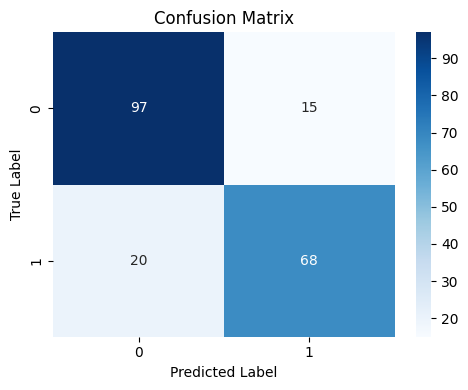

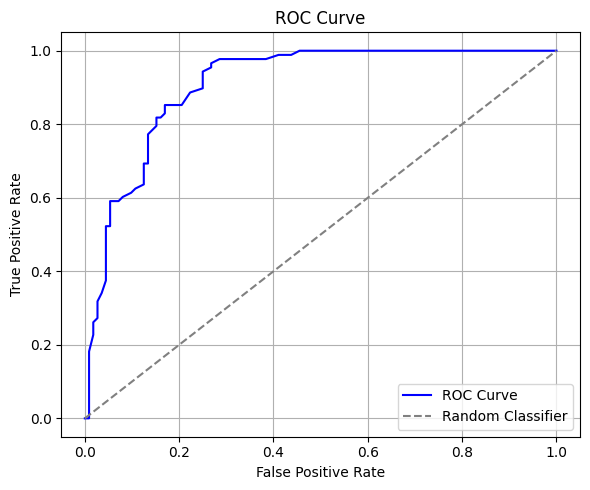

In [9]:
# Simple example using Logistic Regression
# uses seaborn for better visualizations and sklearn's make_classification to generate a sample dataset
import seaborn as sns
from sklearn.datasets import make_classification

def plot_confusion_matrix(cm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_proba):
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))

        tpr.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
        fpr.append(FP / (FP + TN) if (FP + TN) > 0 else 0)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC Curve', color='blue')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_logistic_regression_experiment():
    # Generate data
    X, y = make_classification(
        n_samples=1000,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        n_classes=2,
        random_state=42
    )

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model = LogisticRegression(
        learning_rate=0.05,
        iterations=1000,
        l2_penalty=0.01,
        verbose=True
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Metrics
    acc = accuracy(y_test, y_pred)
    prec = precision(y_test, y_pred)
    rec = recall(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Results
    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC Score  : {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Visualizations
    plot_confusion_matrix(cm)
    plot_roc_curve(y_test, y_proba)

if __name__ == "__main__":
    run_logistic_regression_experiment()